In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r'/content/Retail Sales Data.csv')
data.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-05-15,CUST068,Female,61,Beauty,3,50,150
1,2,2023-06-19,CUST007,Female,28,Beauty,4,50,200
2,3,2023-09-10,CUST097,Female,38,Home,5,300,1500
3,4,2023-07-02,CUST100,Female,63,Beauty,1,50,50
4,5,2023-03-06,CUST012,Female,62,Sports,3,200,600


In [34]:
print('Data Information', data.info())
print('-'*40 + '\n')
print('Data Description', data.describe())
print('-'*40 + '\n')
print('Descriptive statistics', data.describe(include = 'object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
Data Information None
----------------------------------------

Data Description        Transaction ID          Age     Quantity  Price per Unit  Total Amount
count     1000.000000  1000.000000  1000.000000     1000.000000   1000.000000
mean       500.500000    41.534000     2.983000      364.710000   1082.390000
std        288.819436  

### __Create A/B Testing Groups__
- ### **Discount Strategy:** Test if giving discounts (e.g., 10% off) increases sales.

In [35]:
from scipy import stats

def test_discount_strategy(data, category, discount=0.1):
    # Filter by category
    cat_data = data[data["Product Category"] == category].copy()

    # Split into A/B groups
    np.random.seed(42)
    cat_data["Test Group"] = np.random.choice(["A (No Discount)", "B (Discount)"], size=len(cat_data))

    # Apply discount to Group B
    cat_data["Adjusted Price"] = np.where(
        cat_data["Test Group"] == "B (Discount)",
        cat_data["Price per Unit"] * (1 - discount),
        cat_data["Price per Unit"]
    )
    cat_data["Adjusted Revenue"] = cat_data["Quantity"] * cat_data["Adjusted Price"]

    # Compare groups
    grouped = cat_data.groupby("Test Group").agg(
        Avg_Revenue=("Adjusted Revenue", "mean"),
        Total_Revenue=("Adjusted Revenue", "sum"),
        Sample_Size=("Test Group", "count")
    ).reset_index()

    # T-test
    t_stat, p_value = stats.ttest_ind(
        cat_data[cat_data["Test Group"] == "A (No Discount)"]["Adjusted Revenue"],
        cat_data[cat_data["Test Group"] == "B (Discount)"]["Adjusted Revenue"]
    )

    return grouped, p_value

# List of categories to test
categories_to_test = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

# Loop through each category
for category in categories_to_test:
    results, p_value = test_discount_strategy(data, category)

    # Print formatted results
    print(f"{category} Discount Results:")
    print(results)
    print(f"P-value: {p_value:.4f}")
    print("-" * 40 + "\n")

Sports Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)   586.046512        50400.0           86
1     B (Discount)   530.425532        49860.0           94
P-value: 0.1694
----------------------------------------

Beauty Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)   148.214286         8300.0           56
1     B (Discount)   145.519481        11205.0           77
P-value: 0.8104
----------------------------------------

Clothing Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)  1597.402597       123000.0           77
1     B (Discount)  1396.551724       121500.0           87
P-value: 0.0692
----------------------------------------

Electronics Discount Results:
        Test Group  Avg_Revenue  Total_Revenue  Sample_Size
0  A (No Discount)  2955.056180       263000.0           89
1     B (Discount)  2576.842105       244800.0           95

### __Price Increase Sensitivity:__ Test if increasing the price (eg. 10%) affects revenue and purchase behavior.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Simulate price increase test (A: Original Price, B: 10% Increase) for all products
np.random.seed(42)
data["Test Group"] = np.random.choice(["A (Original Price)", "B (10% increase)"], size=len(data))

# Apply the 10% price increase to group B
data["Adjusted Price"] = np.where(
    data["Test Group"] == "B (10% increase)",
    data["Price per Unit"] * 1.1,  # Increase price by 10%
    data["Price per Unit"]  # Keep original price for group A
)

# Calculate adjusted revenue
data["Adjusted Revenue"] = data["Quantity"] * data["Adjusted Price"]

# Compare results
grouped = data.groupby("Test Group").agg(
    Avg_Quantity=("Quantity", "mean"),
    Avg_Revenue=("Adjusted Revenue", "mean"),
    Total_Revenue=("Adjusted Revenue", "sum")
).reset_index()
print("\nPrice Increase Results (All Products):\n", grouped)

# Mann-Whitney U test (small sample, non-normal data)
u_stat, p_value = stats.mannwhitneyu(
    data[data["Test Group"] == "A (Original Price)"]["Adjusted Revenue"],
    data[data["Test Group"] == "B (10% increase)"]["Adjusted Revenue"]
)
print(f"\nMann-Whitney U Test: p = {p_value:.4f}")


Price Increase Results (All Products):
            Test Group  Avg_Quantity  Avg_Revenue  Total_Revenue
0  A (Original Price)      2.997959  1106.591837       542230.0
1    B (10% increase)      2.968627  1165.050980       594176.0

Mann-Whitney U Test: p = 0.7556


- ### __Bundling Strategy:__ Test if selling products in bundles increases total revenue.

In [ ]:
from scipy import stats

# Define the bundle (Beauty + Home)
BUNDLE_PRICE = 320  # Discounted price
INDIVIDUAL_PRICE = 50 + 300  # Beauty (50) + Home (300)

# Identify customers who bought Beauty or Home products
eligible_customers = set(data.loc[data["Product Category"].isin(["Beauty", "Home"]), "Customer ID"].unique())

# Split into control (A) and treatment (B)
np.random.seed(42)
group_assignment = pd.DataFrame({
    "Customer ID": list(eligible_customers),
    "Group": np.random.choice(["A (No Bundle)", "B (Bundle Offered)"], size=len(eligible_customers))
})

# Merge group assignments with transactions
data = pd.merge(data, group_assignment, on="Customer ID", how="left")
data["Group"] = data["Group"].fillna("A (No Bundle)")  # Assign others to control

# Simulate bundle purchases in treatment group (30% adoption rate)
bundle_customers = data[
    (data["Group"] == "B (Bundle Offered)") &
    (data["Product Category"].isin(["Beauty", "Home"]))
]["Customer ID"].unique()

np.random.seed(42)
bundle_adopters = np.random.choice(
    bundle_customers,
    size=int(len(bundle_customers) * 0.3),  # 30% buy the bundle
    replace=False
)

# Remove individual Beauty/Home transactions for bundle adopters
bundle_transactions = data[
    (data["Customer ID"].isin(bundle_adopters)) &
    (data["Product Category"].isin(["Beauty", "Home"]))
].index
data = data.drop(bundle_transactions).reset_index(drop=True)  # Reset index

# Add new bundle transactions
bundle_df = pd.DataFrame({
    "Customer ID": bundle_adopters,
    "Product Category": "Bundle",
    "Quantity": 1,
    "Revenue": BUNDLE_PRICE  # Ensure column name matches your dataset
})

data = pd.concat([data, bundle_df], ignore_index=True)

In [ ]:
# Calculate total revenue by group
revenue = data.groupby("Group")["Total Amount"].sum().reset_index()
print("Total Revenue by Group:\n", revenue)

# Perform statistical test (Mann-Whitney U for non-normal data)
group_a = data[data["Group"] == "A (No Bundle)"]["Total Amount"]
group_b = data[data["Group"] == "B (Bundle Offered)"]["Total Amount"]

u_stat, p_value = stats.mannwhitneyu(group_a, group_b)
print(f"\nMann-Whitney U Test: p = {p_value:.4f}")

Total Revenue by Group:
                 Group  Total Amount
0       A (No Bundle)      494240.0
1  B (Bundle Offered)      560950.0

Mann-Whitney U Test: p = 0.1947


<ipython-input-32-1f03f2dac289>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y='Total Amount', data=revenue, palette=['red', 'pink'])


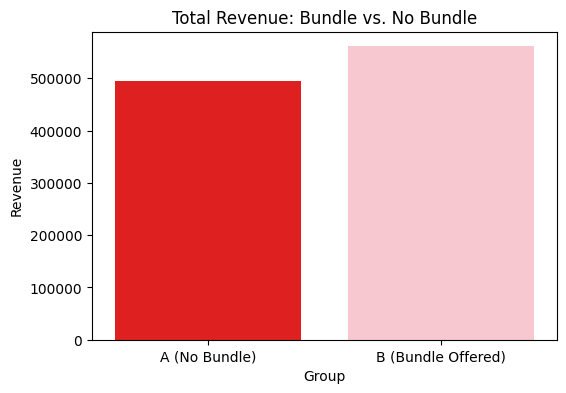

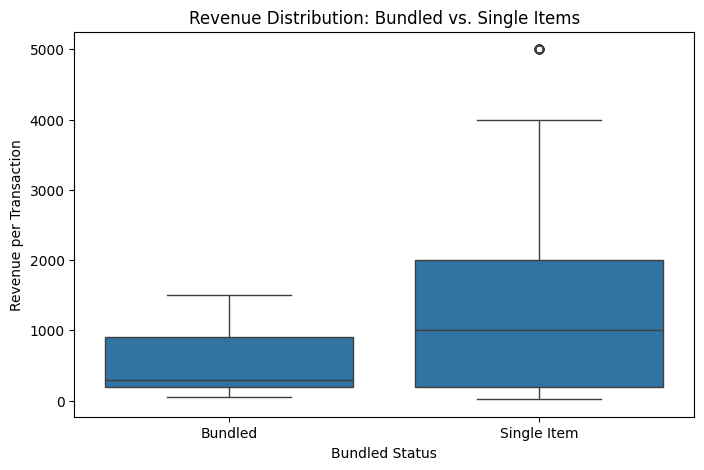

In [ ]:
import matplotlib.pyplot as plt

# Revenue comparison
plt.figure(figsize=(6, 4))
sns.barplot(x='Group', y='Total Amount', data=revenue, palette=['red', 'pink'])
plt.title('Total Revenue: Bundle vs. No Bundle')
plt.ylabel('Revenue')
plt.show()


# Boxplot of revenue per transaction (including both bundled and single items)
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Bundled",
    y="Total Amount",
    data=data  # Use the full dataset, not filtered
)
plt.title("Revenue Distribution: Bundled vs. Single Items")
plt.ylabel("Revenue per Transaction")
plt.xlabel("Bundled Status")
plt.show()

### __Price Elasticity & Revenue Optimization__
### __Visualization: Revenue vs. Price Curves__

Sports:
  Current Price: 200.00
  Optimal Price: 399.90
----------------------------------------


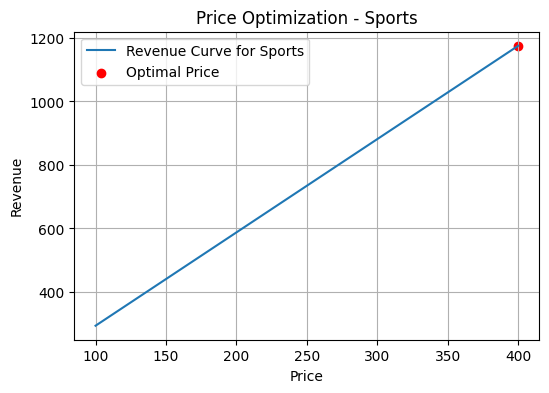

Beauty:
  Current Price: 50.00
  Optimal Price: 99.90
----------------------------------------


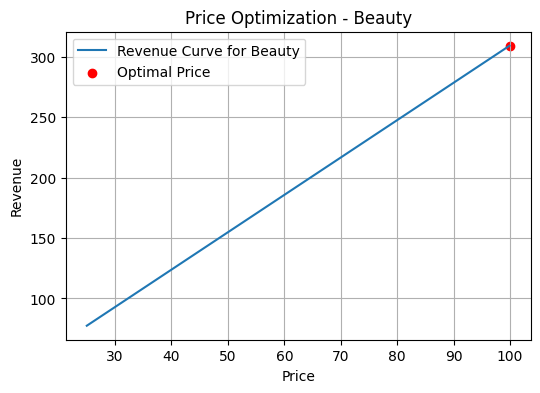

Clothing:
  Current Price: 500.00
  Optimal Price: 999.90
----------------------------------------


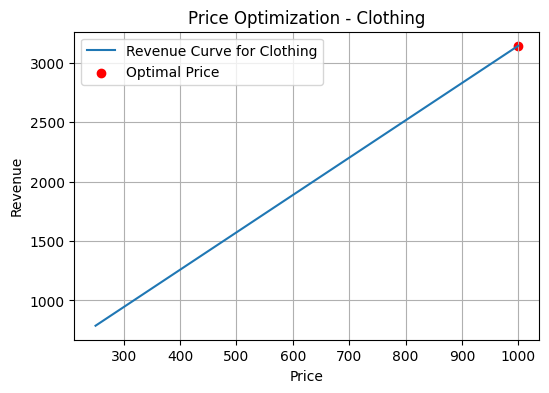

Electronics:
  Current Price: 1000.00
  Optimal Price: 1999.90
----------------------------------------


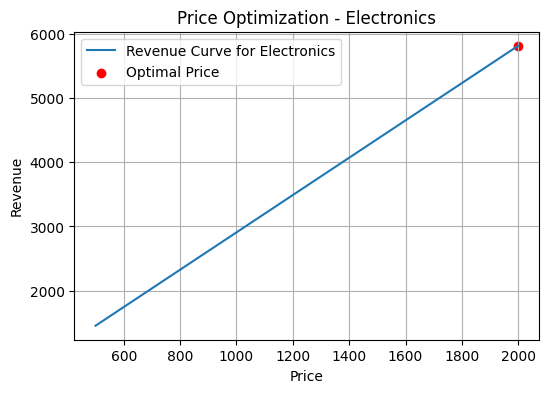

Home:
  Current Price: 300.00
  Optimal Price: 599.90
----------------------------------------


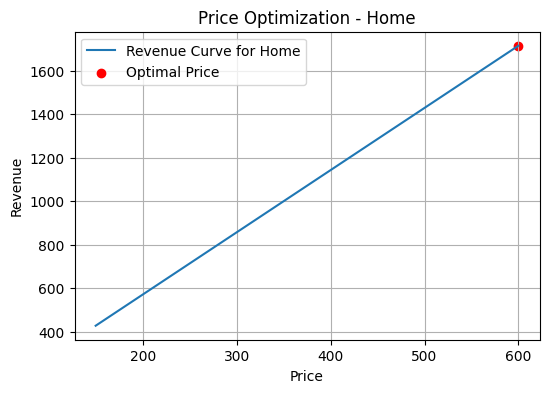

Books:
  Current Price: 20.00
  Optimal Price: 39.90
----------------------------------------


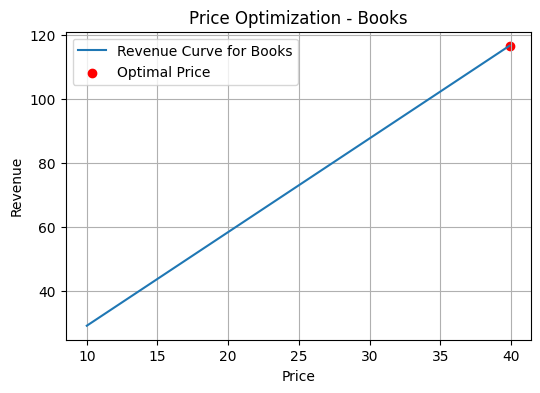

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Define key categories (example: Beauty, Sports, Home)
categories = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

def optimize_pricing(data, category, min_price=0.5, max_price=2.0, step=0.1):
    """
    Optimize prices for a product category using elasticity modeling.
    Returns optimal price and revenue curve.
    """
    # Filter category data
    cat_df = data[data["Product Category"] == category].copy()
    if len(cat_df) < 5:
        print(f"Insufficient data for {category} (n < 5)")
        return None, None

    # Calculate avg price and avg quantity before elasticity calculation
    avg_price = cat_df["Price per Unit"].mean()
    avg_quantity = cat_df["Quantity"].mean()

    # Calculate price elasticity (using linear regression as a proxy)
    X = cat_df[["Price per Unit"]]
    y = cat_df["Quantity"]
    model = LinearRegression()
    model.fit(X, y)
    elasticity = model.coef_[0] * (avg_price / avg_quantity)  # Elasticity formula

    # Simulate revenue at different prices
    prices = np.arange(avg_price * min_price, avg_price * max_price, step)
    quantities = avg_quantity * (prices / avg_price) ** elasticity
    revenues = prices * quantities

    # Find optimal price (max revenue)
    optimal_idx = np.argmax(revenues)
    optimal_price = prices[optimal_idx]

    return optimal_price, (prices, revenues)

# Generate results for all categories
results = {}
for category in categories:
    optimal_price, revenue_curve = optimize_pricing(data, category)
    if optimal_price:
        results[category] = {
            "Current Price": data[data["Product Category"] == category]["Price per Unit"].mean(),
            "Optimal Price": optimal_price,
            "Revenue Curve": revenue_curve
        }

# Print results
for category, data in results.items():
    print(f"{category}:")
    print(f"  Current Price: {data['Current Price']:.2f}")
    print(f"  Optimal Price: {data['Optimal Price']:.2f}")
    print("-" * 40)

    # Plot revenue curve for each category
    plt.figure(figsize=(6, 4))
    plt.plot(data["Revenue Curve"][0], data["Revenue Curve"][1], label=f"Revenue Curve for {category}")
    plt.scatter(data["Optimal Price"], max(data["Revenue Curve"][1]), color='red', label="Optimal Price")
    plt.title(f"Price Optimization - {category}")
    plt.xlabel("Price")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()


### __Customer Segmentation__
Identify price sensitivity by age/gender:

In [ ]:
import pandas as pd

def segment_price_sensitivity(data, categories):
    # Dictionary to store results
    results = {}

    # Iterate over each category
    for category in categories:
        # Filter data for the given product category
        cat_df = data[data["Product Category"] == category]

        # Handle missing data (optional but recommended)
        if cat_df["Age"].isnull().any() or cat_df["Gender"].isnull().any():
            print(f"Warning: Missing data in 'Age' or 'Gender' for {category}.")

        # Segment by age group
        cat_df["Age Group"] = pd.cut(cat_df["Age"], bins=[0, 30, 50, 100], labels=["<30", "30-50", ">50"], right=False)
        age_revenue = cat_df.groupby("Age Group")["Total Amount"].mean()

        # Segment by gender
        gender_revenue = cat_df.groupby("Gender")["Total Amount"].mean()

        # Store results for the current category
        results[category] = {
            "Age Group Revenue": age_revenue,
            "Gender Revenue": gender_revenue
        }

    return results

# Example usage: List of categories
categories = ["Sports", "Beauty", "Clothing", 'Electronics', 'Home', 'Books']

# Get segmented revenue for all categories
segmented_revenue = segment_price_sensitivity(data, categories)

# Print results for each category
for category, rev_data in segmented_revenue.items():
    print(f"\n{category} - Revenue by Age Group:")
    print(rev_data["Age Group Revenue"])
    print(f"\n{category} - Revenue by Gender:")
    print(rev_data["Gender Revenue"])



Sports - Revenue by Age Group:
Age Group
<30      586.956522
30-50    575.342466
>50      603.278689
Name: Total Amount, dtype: float64

Sports - Revenue by Gender:
Gender
Female    559.493671
Male      609.900990
Name: Total Amount, dtype: float64

Beauty - Revenue by Age Group:
Age Group
<30      142.857143
30-50    159.166667
>50      157.692308
Name: Total Amount, dtype: float64

Beauty - Revenue by Gender:
Gender
Female    152.816901
Male      159.677419
Name: Total Amount, dtype: float64

Clothing - Revenue by Age Group:
Age Group
<30      1635.135135
30-50    1583.333333
>50      1518.181818
Name: Total Amount, dtype: float64

Clothing - Revenue by Gender:
Gender
Female    1617.021277
Male      1514.285714
Name: Total Amount, dtype: float64

Electronics - Revenue by Age Group:
Age Group
<30      3375.000000
30-50    2813.953488
>50      2724.137931
Name: Total Amount, dtype: float64

Electronics - Revenue by Gender:
Gender
Female    2974.683544
Male      2857.142857
Name: Total

<ipython-input-12-950d9f7c5992>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df["Age Group"] = pd.cut(cat_df["Age"], bins=[0, 30, 50, 100], labels=["<30", "30-50", ">50"], right=False)
<ipython-input-12-950d9f7c5992>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_revenue = cat_df.groupby("Age Group")["Total Amount"].mean()
<ipython-input-12-950d9f7c5992>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

### __Dynamic Pricing:__

In [ ]:
def dynamic_pricing(inventory_level, demand_forecast):
    base_price = 200  # Base price for Sports
    if inventory_level < 20 and demand_forecast > 0.7:
        return base_price * 1.1  # Surge pricing
    else:
        return base_price * 0.9  # Clearance pricing

### __Promotion Planning:__

In [ ]:
promotion_calendar = {
    "Beauty": ["2023-12-01", "2023-12-15"],  # Discounts during peak periods
    "Sports": ["2023-11-20", "2023-12-31"]    # Holiday season pricing
}

In [ ]:
# Test optimal price for Beauty
beauty_test = data[data["Product Category"] == "Beauty"].copy()
beauty_test["Group"] = np.random.choice([47.5, 50], size=len(beauty_test))

Product Category  Beauty  Books  Clothing  Electronics  Home  Sports
Date                                                                
2023-01-01           0.0    0.0       5.0          2.0   6.0     1.0
2023-01-02           0.0    0.0       5.0          0.0   0.0     3.0
2023-01-03           0.0    0.0       0.0          3.0   0.0     5.0
2023-01-04           2.0    3.0       1.0          4.0   0.0     4.0
2023-01-05           0.0    0.0       5.0          1.0   0.0     0.0


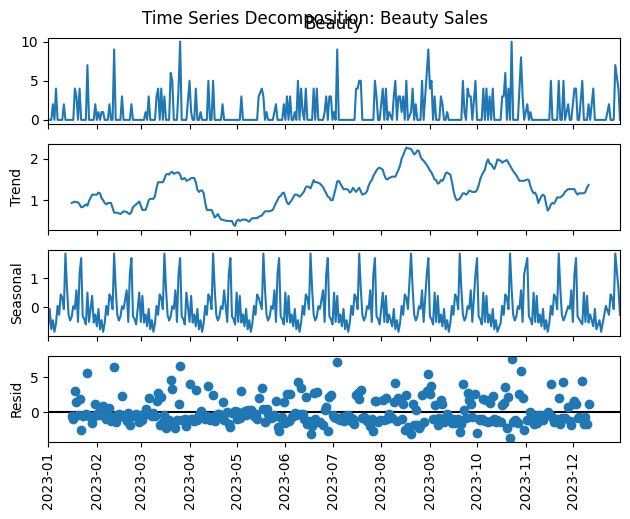

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Convert 'Date' to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Aggregate daily sales by product category
daily_sales = data.groupby(["Date", "Product Category"])["Quantity"].sum().unstack().fillna(0)
print(daily_sales.head())

# Example: Decompose Beauty category sales
beauty_sales = daily_sales["Beauty"]
decomposition = seasonal_decompose(beauty_sales, model="additive", period=30)  # Monthly seasonality

# Plot decomposition
decomposition.plot()
plt.suptitle("Time Series Decomposition: Beauty Sales")
plt.xticks(rotation = 90)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Beauty   No. Observations:                  275
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -589.759
Date:                Sat, 01 Mar 2025   AIC                           1191.518
Time:                        14:19:27   BIC                           1213.197
Sample:                             0   HQIC                          1200.219
                                - 275                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8130      0.056    -14.455      0.000      -0.923      -0.703
ar.L2         -0.5738      0.073     -7.884      0.000      -0.716      -0.431
ar.L3         -0.4690      0.067     -6.977      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


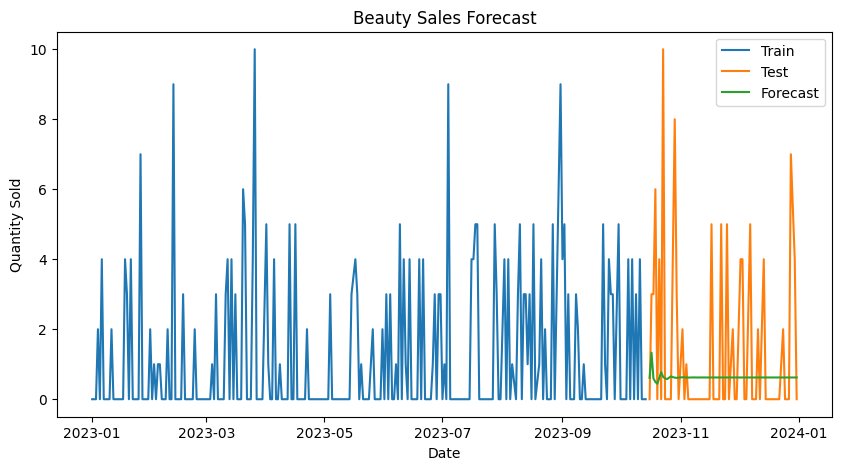

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split data into train/test sets
train = beauty_sales[:int(len(beauty_sales) * 0.8)]
test = beauty_sales[int(len(beauty_sales) * 0.8):]

# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # (p, d, q) = (5, 1, 0)
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.2f}")

# Plot forecast vs. actual
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.title("Beauty Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp3dfrhuf/lj6cus61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp3dfrhuf/dwxzh9sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19661', 'data', 'file=/tmp/tmpp3dfrhuf/lj6cus61.json', 'init=/tmp/tmpp3dfrhuf/dwxzh9sf.json', 'output', 'file=/tmp/tmpp3dfrhuf/prophet_modelmgw5r8rh/prophet_model-20250301141945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:19:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


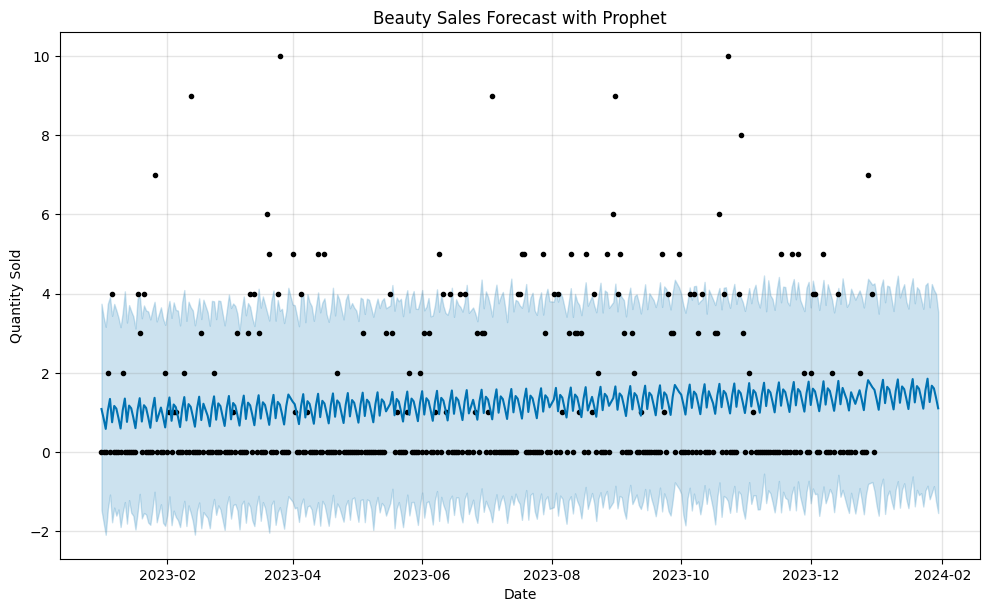

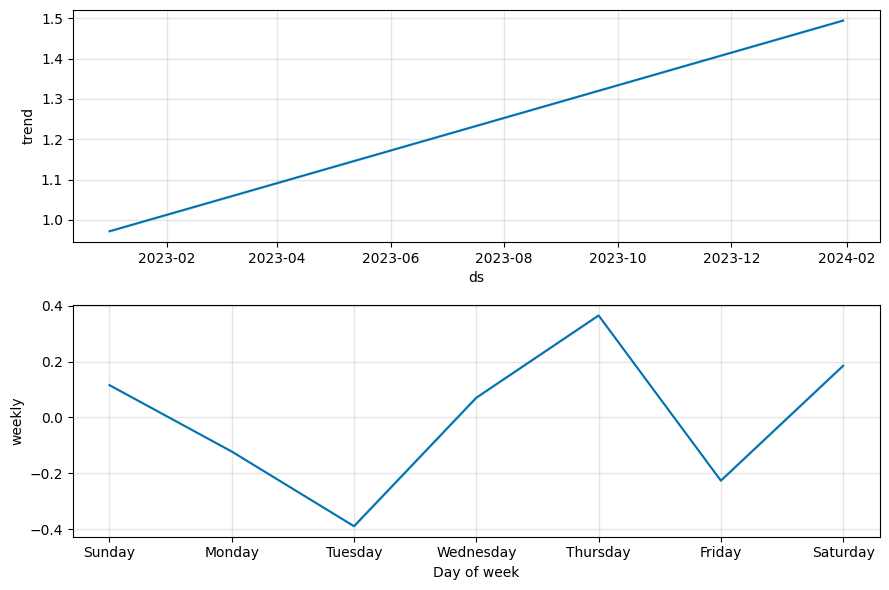

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp3dfrhuf/1rwn9a4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp3dfrhuf/ni3h0p36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39592', 'data', 'file=/tmp/tmpp3dfrhuf/1rwn9a4x.json', 'init=/tmp/tmpp3dfrhuf/ni3h0p36.json', 'output', 'file=/tmp/tmpp3dfrhuf/prophet_model8kdn85pr/prophet_model-20250301141947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

                yhat
ds                  
2023-01-01  1.087570
2023-01-02  0.851378
2023-01-03  0.585654
2023-01-04  1.046535
2023-01-05  1.341987


In [ ]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = beauty_sales.reset_index()
prophet_df.columns = ["ds", "y"]

# Fit Prophet model
model = Prophet()
model.fit(prophet_df)

# Create future dataframe (e.g., next 30 days)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Beauty Sales Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.show()

# Plot components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

forecasts = {}
for category in daily_sales.columns:
    # Prepare data
    sales = daily_sales[category].reset_index()
    sales.columns = ["ds", "y"]

    # Fit Prophet model
    model = Prophet()
    model.fit(sales)

    # Forecast next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Store results
    forecasts[category] = forecast[["ds", "yhat"]].set_index("ds")

# Example: Beauty forecast
print(forecasts["Beauty"].head())

### __Visualization: Demand Forecast by Category__

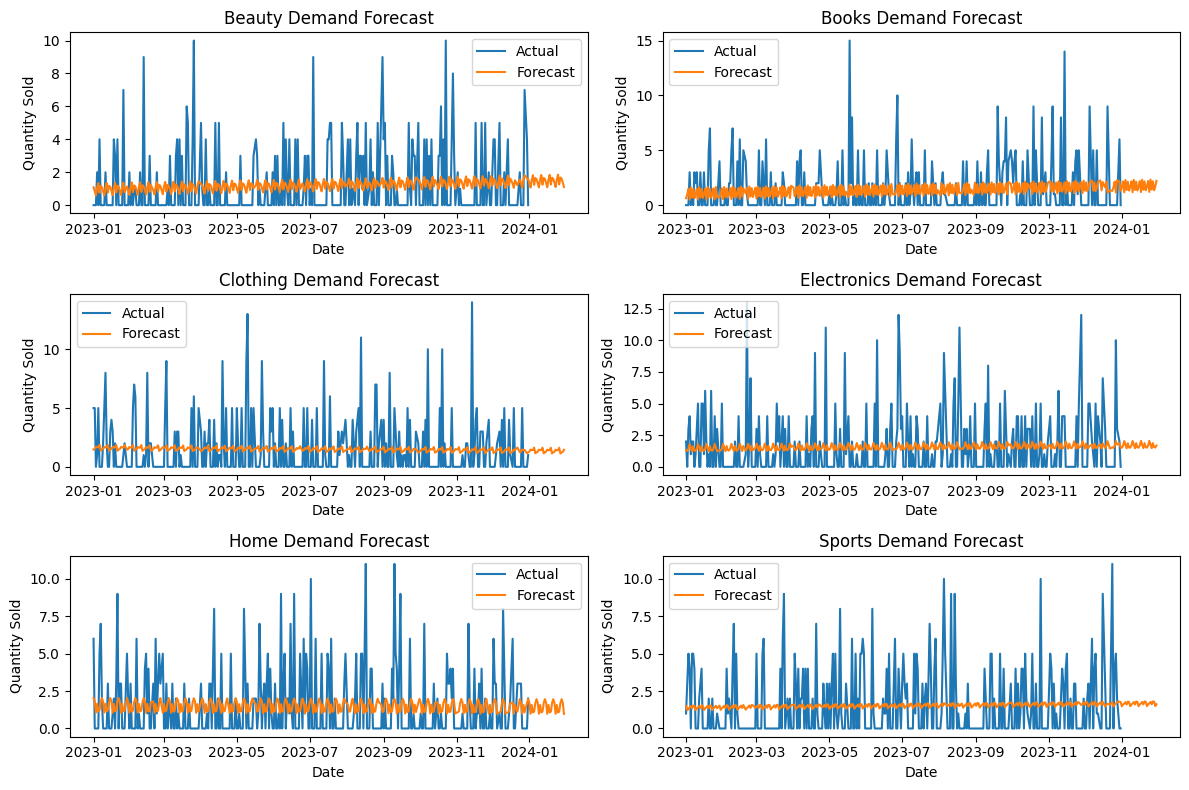

In [ ]:
plt.figure(figsize=(12, 8))
for idx, (category, forecast) in enumerate(forecasts.items(), 1):
    plt.subplot(3, 2, idx)
    plt.plot(daily_sales[category], label="Actual")
    plt.plot(forecast["yhat"], label="Forecast")
    plt.title(f"{category} Demand Forecast")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
%%writefile dashboard.py
import pandas as pd
import numpy as np
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet

# Load your data
data = pd.DataFrame(data)
data["Date"] = pd.to_datetime(data["Date"])

# Aggregate daily sales by product category
daily_sales = data.groupby(["Date", "Product Category"])["Quantity"].sum().unstack().fillna(0)

# Streamlit app
st.set_page_config(page_title="Pricing & Demand Dashboard", layout="wide")

# Title
st.title("Pricing Optimization & Demand Forecasting Dashboard")

# Sidebar for user inputs
st.sidebar.header("User Inputs")
selected_category = st.sidebar.selectbox(
    "Select Product Category",
    daily_sales.columns,
    index=0  # Default to first category
)

# Tabs for different views
tab1, tab2 = st.tabs(["Demand Forecast", "Price Optimization"])

# Demand Forecast Tab
with tab1:
    st.header(f"Demand Forecast for {selected_category}")

    # Prepare data for Prophet
    sales = daily_sales[selected_category].reset_index()
    sales.columns = ["ds", "y"]

    # Fit Prophet model
    model = Prophet()
    model.fit(sales)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Plot forecast
    fig = px.line(forecast, x="ds", y="yhat", title=f"{selected_category} Demand Forecast")
    fig.add_scatter(x=sales["ds"], y=sales["y"], mode="lines", name="Actual")
    st.plotly_chart(fig, use_container_width=True)

# Price Optimization Tab
with tab2:
    st.header(f"Price Optimization for {selected_category}")

    # Simulate price optimization
    prices = np.linspace(10, 100, 50)  # Example price range
    elasticity = -1.5  # Placeholder for elasticity
    quantities = 100 * (prices / 50) ** elasticity  # Simulated demand
    revenues = prices * quantities

    # Find optimal price
    optimal_price = prices[np.argmax(revenues)]

    # Plot revenue curve
    fig = px.line(x=prices, y=revenues, title=f"{selected_category} Price Optimization")
    fig.add_vline(x=optimal_price, line_dash="dash", line_color="red",
                  annotation_text=f"Optimal Price: {optimal_price:.2f}")
    fig.update_xaxes(title="Price")
    fig.update_yaxes(title="Revenue")
    st.plotly_chart(fig, use_container_width=True)

Overwriting dashboard.py


In [ ]:
from pyngrok import ngrok

!streamlit run dashboard.py

# Get the URL for external access
url = ngrok.connect(port='8501')
print(f"Streamlit App URL: {url}")




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.184.136:8501

